In [178]:
import librosa
import numpy as np
import pandas as pd
import math
import os
import IPython.display as ipd
import pandas as pd
import librosa
import librosa.display

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,15


VERBOSE=False

# 1. Extract Audio

In [127]:
audio_file='beckerish-intro.wav'
x, fs = librosa.load(audio_file)
x = librosa.resample(x, fs, 16000)
fs = 16000
print(x.shape)

x_norm = x
x_norm /= np.max(np.abs(x_norm),axis=0)

ipd.Audio(x_norm, rate=fs)

(215366,)


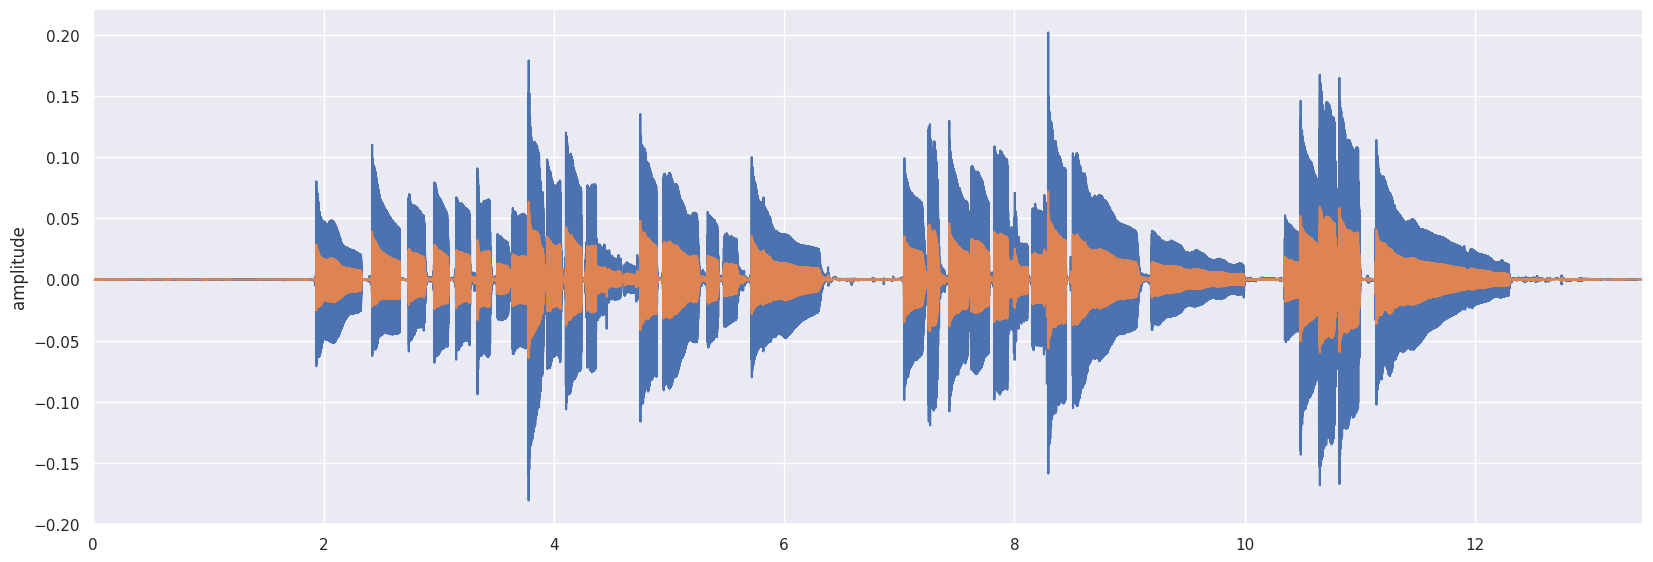

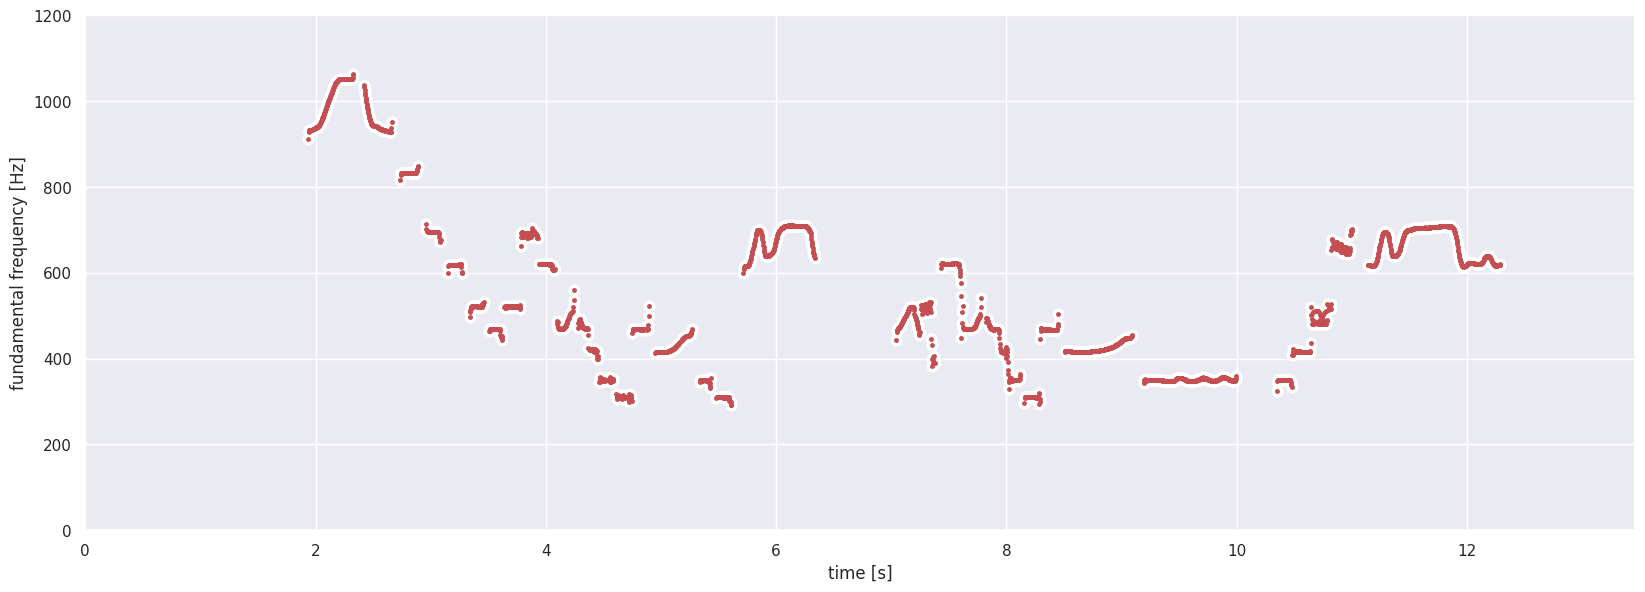

In [128]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

snd = parselmouth.Sound(audio_file)
plt.figure()
plt.subplot(211)
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.ylabel("amplitude")
plt.show() # 


def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, '.', markersize=15, color='w')
    plt.plot(pitch.xs(), pitch_values, '.', markersize=5, color='r')
    plt.grid(True)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    
# pitch = snd.to_pitch() 
pitch =snd.to_pitch_ac(pitch_floor=250, pitch_ceiling=1200)

# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

# draw_spectrogram(spectrogram)
plt.subplot(212)
# plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.show()

In [129]:
sf_data = {
    'name': audio_file.split('.')[0],
    'samples': [x],
    'fs': fs
}
sf_data = pd.DataFrame(data=sf_data)


In [130]:
from src.feature_extraction import *

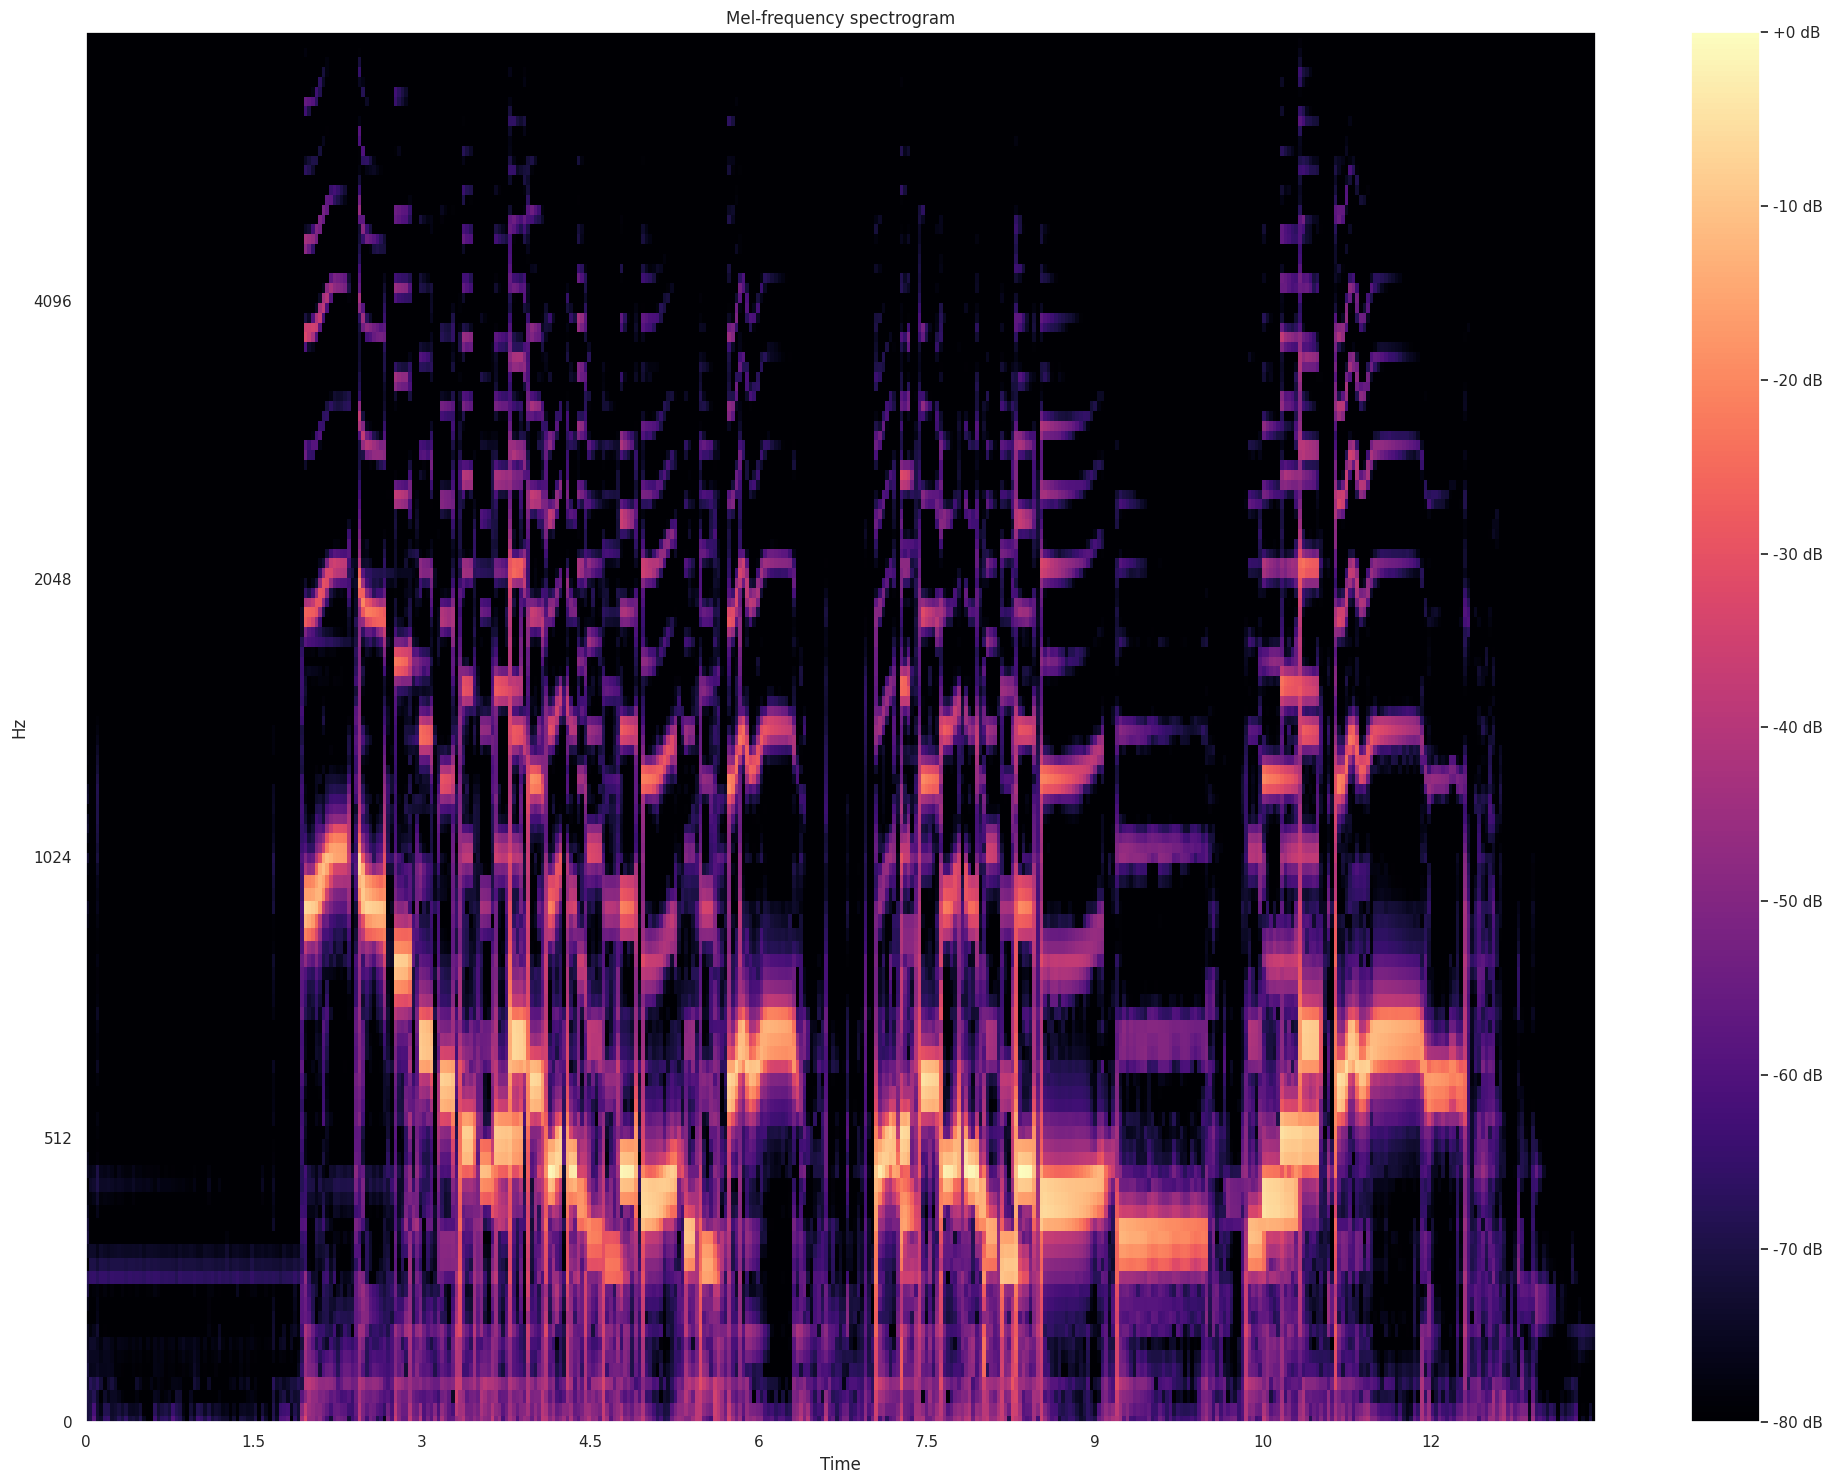

In [131]:
soundfile_df= compute_mel_spectrograms(sf_data)

import librosa.display
import librosa
librosa.display.specshow(soundfile_df['512'][0].T, x_axis='time',
                              y_axis='mel', sr=16000,
                              fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# 2. Process spectrogram
* Normalise
* Zero-pad
* Format inputs for NN input

In [135]:
soundfile_df_process = soundfile_df.copy(deep=True)

ws=[512, 1024, 2048, 4096, 8192, 16384]
n_frames = 782
# Process spectrograms:
#.....normalize
#.....zero-pad
#.....re-shape
for w in ws:
    # Get mel spectrogram
    mel_spec = soundfile_df_process[str(w)][0]
    # Normalise
    mel_spec_norm = librosa.util.normalize(mel_spec)
    # Zero-pad to input length
    mel_spec_pad = np.pad(mel_spec_norm, ((0, n_frames-mel_spec_norm.shape[0]), (0, 0)), 'constant')
    # Update DataFrame
    soundfile_df_process[str(w)][0] = mel_spec_pad
    
soundfile_df_process = soundfile_df_process.drop(columns="name")

In [172]:
# Prepare inputs
input_spec = []
for w in soundfile_df_process.values[0]:
    _w = np.expand_dims(w, axis=0)
    _w_sh = _w.shape
    _w = np.reshape(_w, (_w_sh[2], _w_sh[1], _w_sh[0]))
    input_spec.append(_w)

In [173]:
print(input_spec[0].shape)

(128, 782, 1)


# *. Get test inputs

In [168]:
from src.data_preparation import SMTGuitar 

data_root = "/homes/alb30/datasets/"

# Initialise Dataset Handler
smt_guitar = SMTGuitar(data_root)
# Load data
data_loaded = smt_guitar.load_data(path='data/')

Data loaded successfully


In [157]:
ws=[512, 1024, 2048, 4096, 8192, 16384]

train_data_folder = 'data/'
X_train_data =[]
X_test_data = []

y_train = np.load(train_data_folder+'y_train.npy')
y_test = np.load(train_data_folder+'y_test.npy')
label_weights = np.load(train_data_folder+'label_weights.npy')
for idx in range(len(ws)):
    X_train_data.append(np.load(train_data_folder+str(idx)+'_train_mel.npy'))
    X_test_data.append(np.load(train_data_folder+str(idx)+'_test_mel.npy'))
    
train_data_loaded=False
if(len(X_train_data) == len(ws)):
    train_data_loaded=True
    
# Number of features
n_features = X_train_data[0].shape[1]
# Number of frames
n_frames = X_train_data[0].shape[2]

# Define input shape
input_shape = (n_features, n_frames, 1)

# 3. Define Network

In [174]:
input_shape = input_spec[0].shape

In [179]:
from src.models import *

m = MyModel(input_shape)
m.define_layers()

strong_model=Model(inputs=m.layers['in'], outputs=m.layers['re_out'])
strong_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
if VERBOSE:
    strong_model.summary() 

weak_model=Model(inputs=m.layers['in'], outputs=m.layers['cl_out'])
weak_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
if VERBOSE:
    weak_model.summary() 

if VERBOSE:
    from keras.utils.vis_utils import plot_model
    plot_model(weak_model, to_file='weak_model.png', show_shapes=True, show_layer_names=True)
    plot_model(strong_model, to_file='strong_model.png', show_shapes=True, show_layer_names=True)

# 5. Turn frame annotations to sample-level annotations

In [246]:
_data = np.random.rand(782,6)
print(_data.shape)

(782, 6)


In [249]:
def frame_to_samples(frame_annotations, fs=16000, window=512, overlap=0.5):
    samples_per_frame = int(window*overlap)
    sample_annotations = []
    for _d in frame_annotations:
        __d = np.tile(_d,(samples_per_frame ,1))
        sample_annotations.append(__d)

    sample_annotations = np.concatenate( sample_annotations, axis=0)
    return sample_annotations

In [250]:
sample_annotations = frame_to_samples(_data)

## Plot sample-level annotations

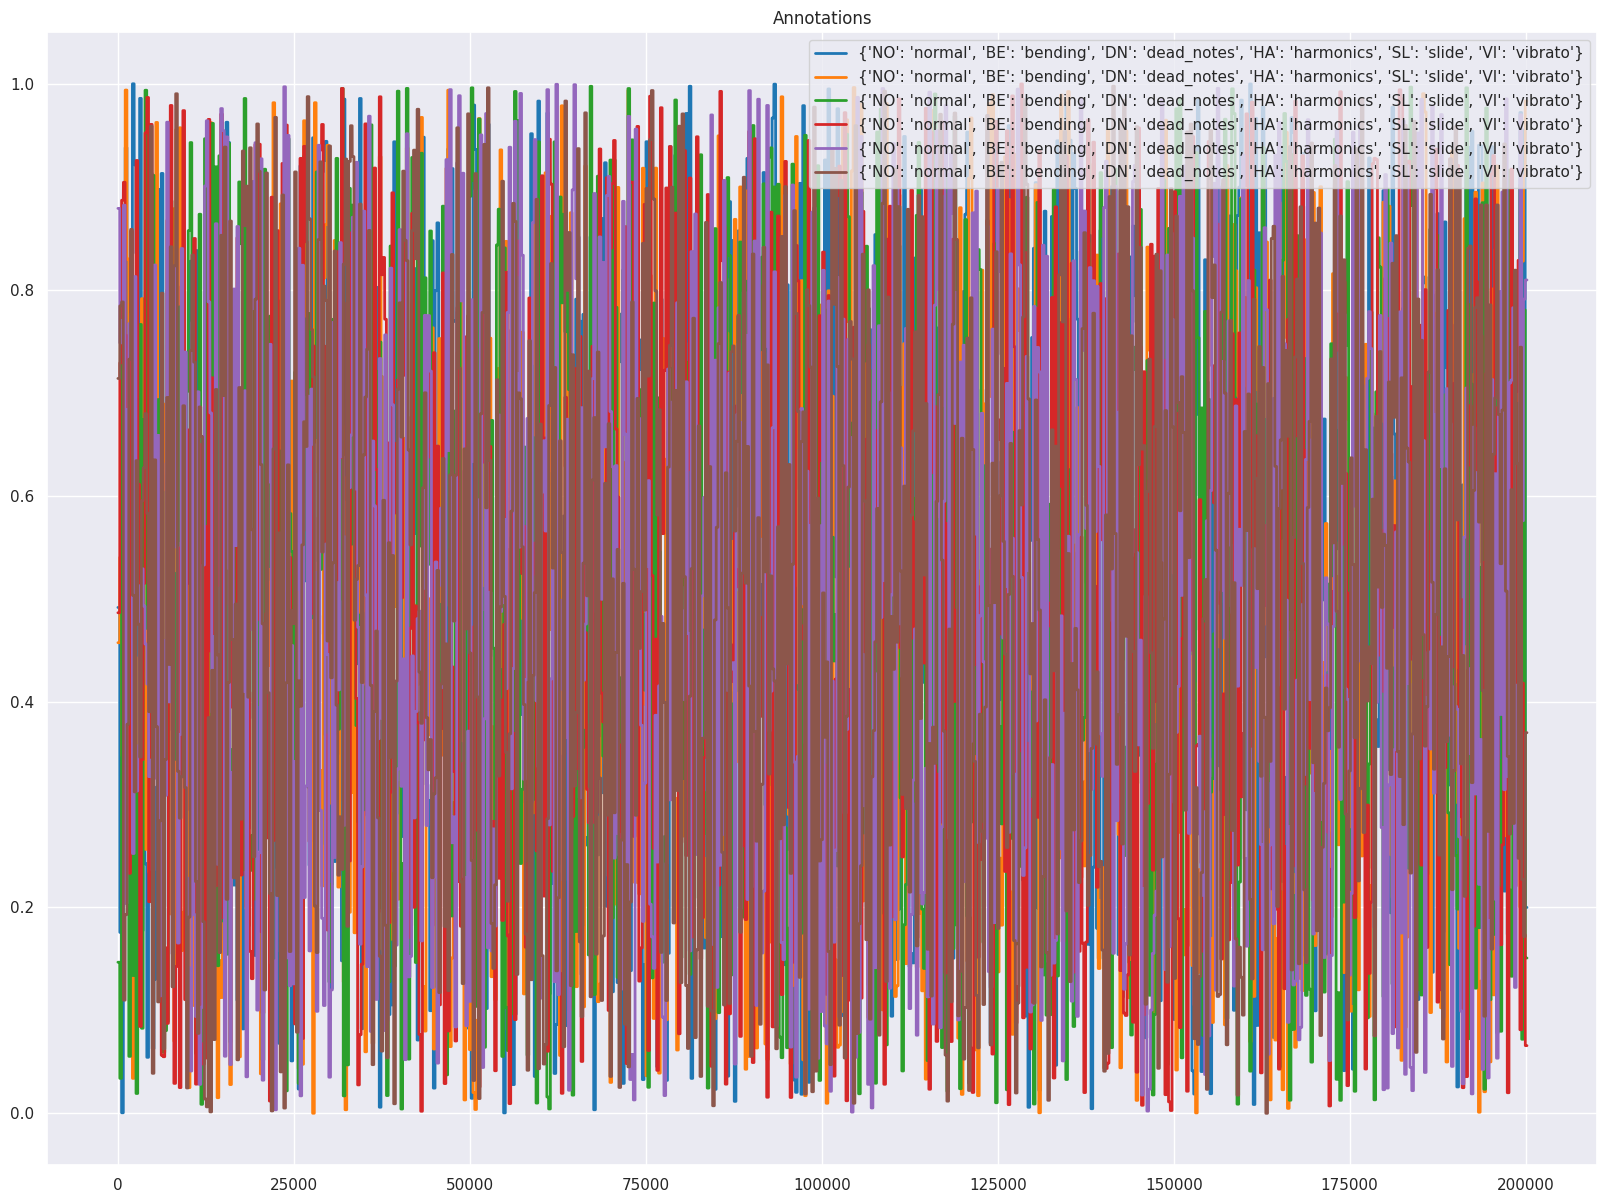

In [251]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
styles = smt_guitar.styles['expression']

signals = []
for i, exp in enumerate(styles.keys()):
    annot = {'name': styles, 'y': sample_annotations[:, i], 'color': colors[i], 'linewidth':2}
    signals.append(annot)

fig, ax = plt.subplots()
for signal in signals:
    ax.plot(signal['y'],
            color=signal['color'],
            linewidth=signal['linewidth'],
            label=signal['name'])

# Enable legend
ax.legend()
ax.set_title('Annotations')
plt.show()